In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
	sys.path.append(nb_dir)

In [2]:
import torch
import torch.nn as nn
from torch.optim.radam import RAdam
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random
from tqdm import trange

from general_utils import AttrDict
from reward_induced.src.reward_predictor_model import RewardPredictorModel, R_CLASSES_BASE
from sprites_datagen.moving_sprites import MovingSpriteDataset
from sprites_datagen.rewards import *


/home/thisiswooyeol/anaconda3/envs/2024Spring/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train reward-induced representations with **RPM image encoder**

In [3]:
# some hyperparameters
image_shape = (3, 64, 64)
n_frames = 5   # number of conditioning frames
T_future = 25  # number of future frames to predict rewards for
batch_size = 64

lr = 1e-3
n_iter = 2_000
log_interval = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=2,      # number of shapes per trajectory
        rewards=[AgentXReward, AgentYReward, TargetXReward, TargetYReward],
        batch_size=batch_size,
    )

dataset = MovingSpriteDataset(spec)
training_data = DataLoader(dataset, batch_size=batch_size)

In [5]:
def train_RPM(model, training_data, device, is_complete=True):
	loss_fn = nn.MSELoss()
	optimizer = RAdam(model.parameters(), lr=lr)

	losses = []
	model.to(device)
	print(f'[INFO] Training complete reward predictor model on device: {device} ...')

	for itr in trange(n_iter):
		# considering incomplete reward annotations
		reward_type_list = random.sample(R_CLASSES_BASE, k=3) if not is_complete else R_CLASSES_BASE

		# get trajectories from MovingSpriteDataset
		data = next(iter(training_data))
		frames = data['images'].to(device)
		rewards = torch.stack([ data['rewards'][r] for r in reward_type_list ]).to(device)

		# predict rewards with RPM
		_, pred_rewards = model(
			frames=frames,
			reward_type_list=reward_type_list
		)
		pred_rewards = torch.stack([ pred_rewards[r] for r in reward_type_list ])

		# compute loss for each reward type
		loss = loss_fn(pred_rewards, rewards[:, :, -T_future:])
		losses.append(loss.item())

		if (itr+1) % log_interval == 0:
			print(f'[{itr+1} / {n_iter}] RPM loss: {loss.item()}')

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

	return losses

### (a) Train with complete reward annotation

In [6]:
model = RewardPredictorModel(image_shape, n_frames, T_future)

In [7]:
losses_complete_reward = train_RPM(model, training_data, device, is_complete=True)

[INFO] Training complete reward predictor model on device: cuda ...


 10%|█         | 200/2000 [01:17<11:57,  2.51it/s]

[200 / 2000] RPM loss: 0.05247630178928375


 20%|██        | 400/2000 [02:34<10:24,  2.56it/s]

[400 / 2000] RPM loss: 0.021538138389587402


 30%|███       | 600/2000 [03:52<08:34,  2.72it/s]

[600 / 2000] RPM loss: 0.004036432597786188


 40%|████      | 800/2000 [05:03<05:39,  3.53it/s]

[800 / 2000] RPM loss: 0.002577203558757901


 50%|█████     | 1000/2000 [06:05<05:34,  2.99it/s]

[1000 / 2000] RPM loss: 0.0017880520317703485


 60%|██████    | 1200/2000 [07:00<03:38,  3.66it/s]

[1200 / 2000] RPM loss: 0.0012934484984725714


 70%|███████   | 1400/2000 [07:55<02:47,  3.58it/s]

[1400 / 2000] RPM loss: 0.0010653355857357383


 80%|████████  | 1600/2000 [08:52<01:50,  3.63it/s]

[1600 / 2000] RPM loss: 0.0010462746722623706


 90%|█████████ | 1800/2000 [10:41<02:23,  1.39it/s]

[1800 / 2000] RPM loss: 0.0010022665373981


100%|██████████| 2000/2000 [12:52<00:00,  2.59it/s]

[2000 / 2000] RPM loss: 0.0007996894419193268


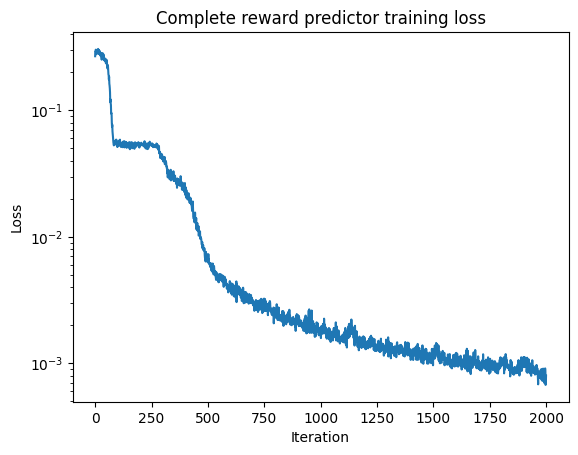

In [8]:
# Visualize the losses
plt.plot(losses_complete_reward)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Complete reward predictor training loss')
plt.show()

In [9]:
PATH = 'models/complete_RPM_1e-3_2K.pth'
torch.save(model.state_dict(), PATH)

In [10]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(PATH))  # test save and load

<All keys matched successfully>

### (b) Train with incomplete reward annotation

In [11]:
model = RewardPredictorModel(image_shape, n_frames, T_future)

In [12]:
losses_incomplete_reward = train_RPM(model, training_data, device, is_complete=False)

[INFO] Training complete reward predictor model on device: cuda ...


 10%|█         | 200/2000 [02:17<19:12,  1.56it/s]

[200 / 2000] RPM loss: 0.056800030171871185


 20%|██        | 400/2000 [04:34<23:22,  1.14it/s]

[400 / 2000] RPM loss: 0.05590788647532463


 30%|███       | 600/2000 [07:05<15:15,  1.53it/s]

[600 / 2000] RPM loss: 0.03144358843564987


 40%|████      | 800/2000 [09:25<15:19,  1.31it/s]

[800 / 2000] RPM loss: 0.017820795997977257


 50%|█████     | 1000/2000 [11:28<09:30,  1.75it/s]

[1000 / 2000] RPM loss: 0.010326657444238663


 60%|██████    | 1200/2000 [14:00<10:46,  1.24it/s]

[1200 / 2000] RPM loss: 0.004444448743015528


 70%|███████   | 1400/2000 [16:25<07:05,  1.41it/s]

[1400 / 2000] RPM loss: 0.004743446595966816


 80%|████████  | 1600/2000 [18:51<04:48,  1.39it/s]

[1600 / 2000] RPM loss: 0.0028944711666554213


 90%|█████████ | 1800/2000 [21:09<02:19,  1.43it/s]

[1800 / 2000] RPM loss: 0.003200445557013154


100%|██████████| 2000/2000 [23:30<00:00,  1.42it/s]

[2000 / 2000] RPM loss: 0.0034217345528304577


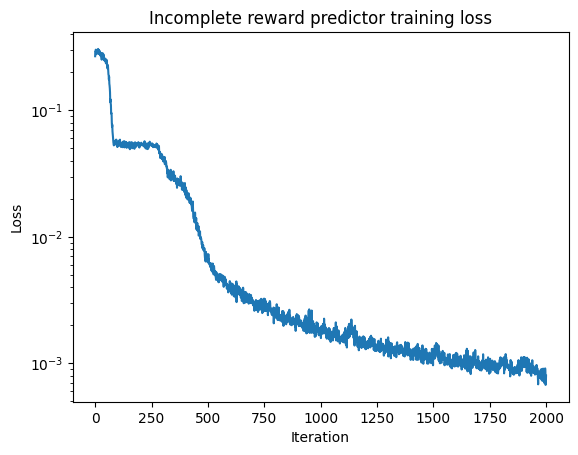

In [13]:
plt.plot(losses_complete_reward)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Incomplete reward predictor training loss')
plt.show()

In [14]:
PATH = 'models/incomplete_RPM_1e-3_2K.pth'
torch.save(model.state_dict(), PATH)

In [15]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(PATH))  # test save and load

<All keys matched successfully>

# Test trained RPM

In [16]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load('models/complete_RPM_1e-3_2K.pth'))
model.to(device)

RewardPredictorModel(
  (image_encoder): ImageEncoder(
    (convs): Sequential(
      (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (projection): Linear(in_features=128, out_features=64, bias=True)
  )
  (predictor_lstm): PredictorLSTM(
    (lstm): LSTM(64, 64, batch_first=True)
  )
  (reward_head_mlp): ModuleDict(
    (agent_x): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_feature

In [17]:
data = next(iter(training_data))
frames = data['images'].to(device)
rewards = torch.stack([ data['rewards'][r] for r in R_CLASSES_BASE ]).to(device)
rewards = rewards[:, :, -T_future:]

In [18]:
future_repr, pred_rewards = model(
    frames=frames,
    reward_type_list=R_CLASSES_BASE
)
pred_rewards = torch.stack([ pred_rewards[r] for r in R_CLASSES_BASE ])

print(f'mean error: {torch.mean(torch.abs(rewards - pred_rewards))}')
print(f'max  error: {torch.max(torch.abs(rewards - pred_rewards))}')

mean error: 0.02034175768494606
max  error: 0.14681124687194824
